# **Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# **Step 2: Load Dataset and Check Info.**

In [2]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.shape

(5110, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# **Step 3: Exploratory Data Analysis (EDA)**

## **Target Distribution**

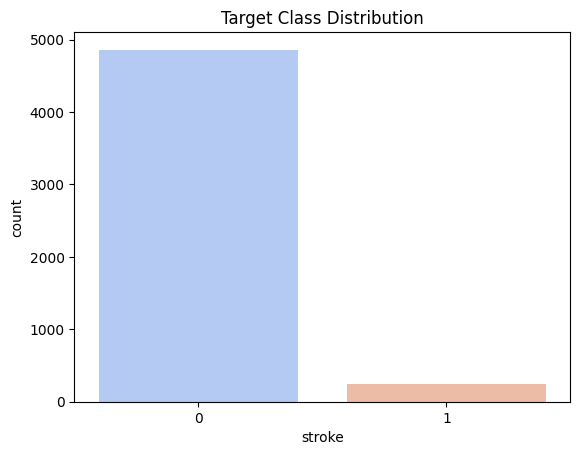

In [6]:
sns.countplot(x="stroke", data=df, palette="coolwarm")
plt.title("Target Class Distribution")
plt.show()

## **Numerical Features Distributions**

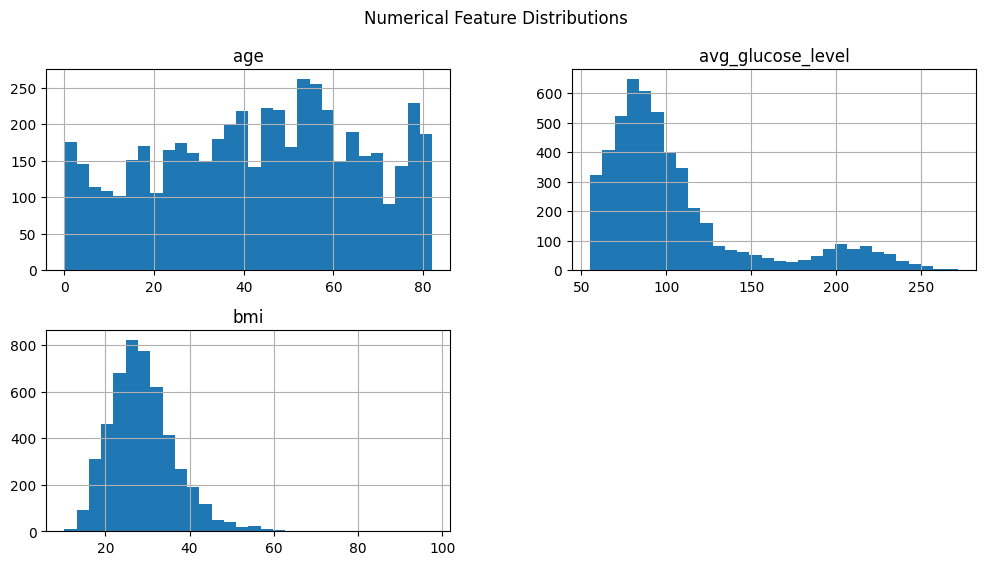

In [7]:
num_cols = ["age","avg_glucose_level","bmi"]
df[num_cols].hist(figsize=(12,6), bins=30)
plt.suptitle("Numerical Feature Distributions")
plt.show()

## **Countplots for Categorical Features**

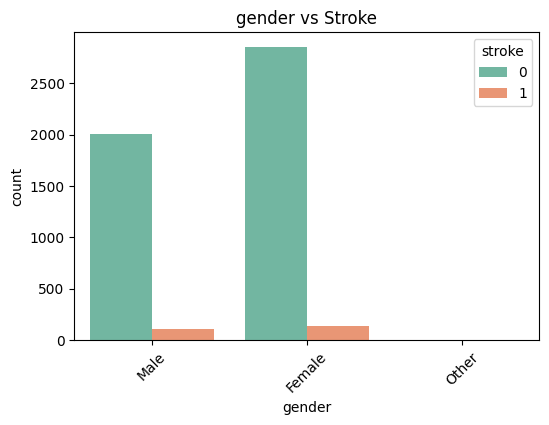

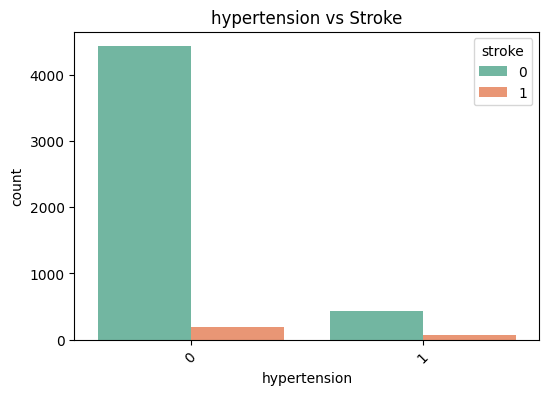

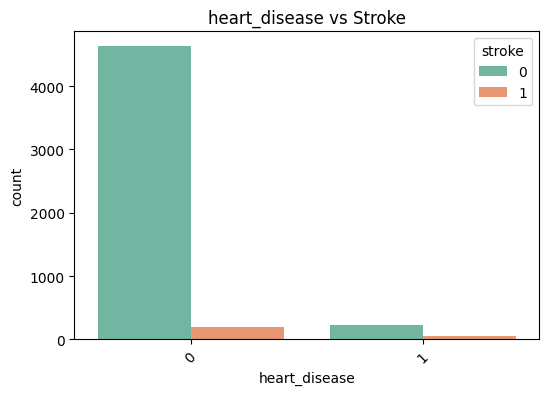

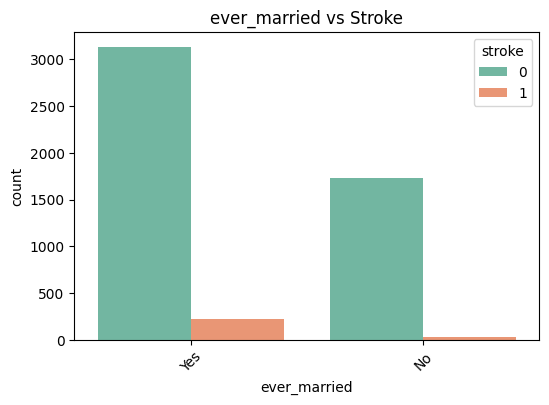

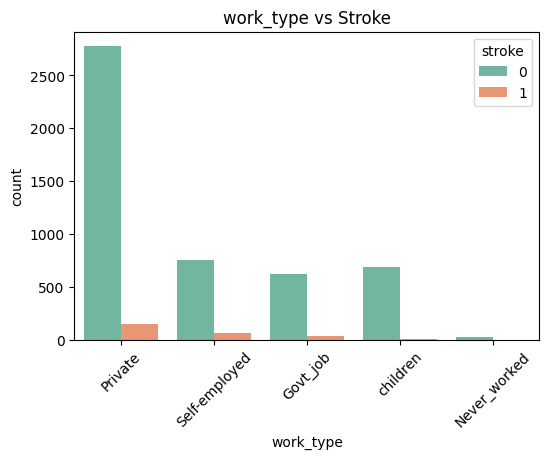

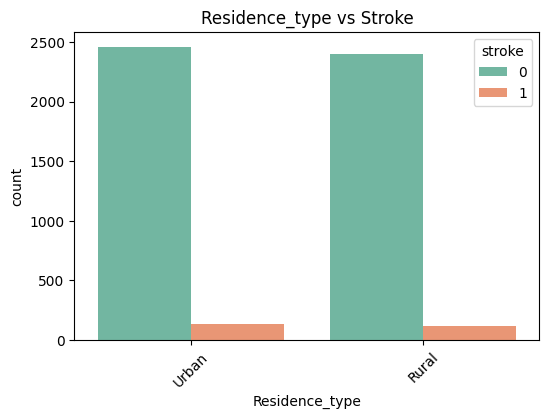

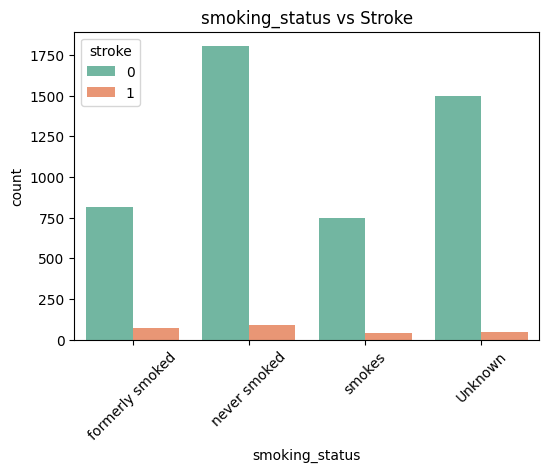

In [8]:
cat_cols = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status"]
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="stroke", data=df, palette="Set2")
    plt.title(f"{col} vs Stroke")
    plt.xticks(rotation=45)
    plt.show()


## **Correlation Heatmap**

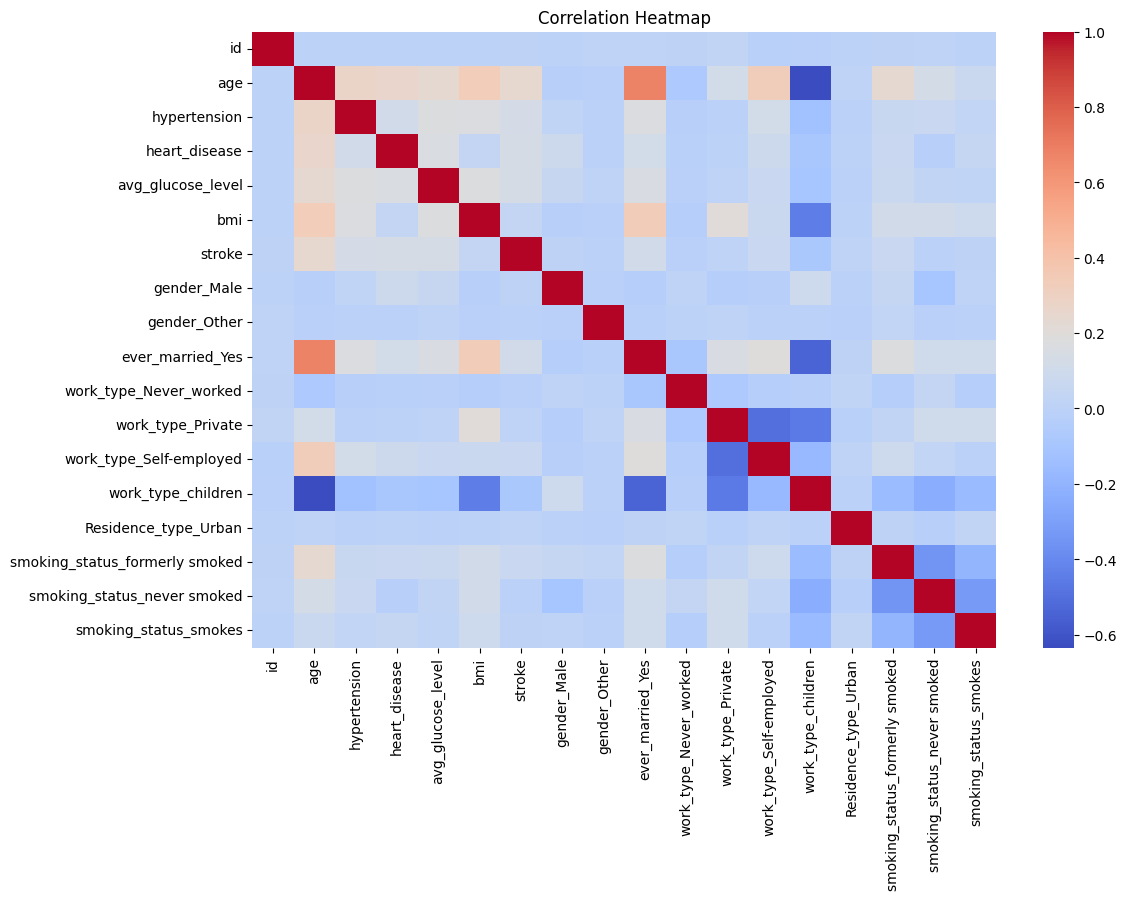

In [9]:
#encode categorical temporarily
df_temp = df.copy()
df_temp = pd.get_dummies(df_temp, drop_first=True)
plt.figure(figsize=(12,8))
sns.heatmap(df_temp.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# **Step 4: Data Cleaning & Preprocessing**

In [10]:
df = df.drop("id", axis=1)
df["bmi"].fillna(df["bmi"].median(), inplace=True)

X = df.drop("stroke", axis=1)
y = df["stroke"]
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numerical = X.select_dtypes(include=["int64","float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Step 5: Define Models**

In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# **Step 6: Train & Evaluate Untuned Models**

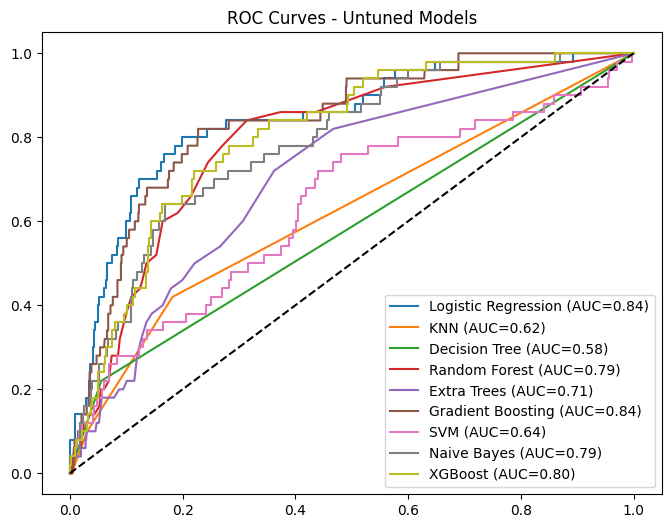

In [12]:
results = {}
plt.figure(figsize=(8,6))

for name, model in models.items():
    clf = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    results[name] = [acc, prec, rec, f1, roc]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves - Untuned Models")
plt.show()

In [13]:
untuned_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1","ROC-AUC"]).T

## **Untuned Models Accuracy**

In [14]:
print("\nUntuned Models Accuracy:\n")
print(untuned_df[["Accuracy"]])

best_model_name = untuned_df["Accuracy"].idxmax()
best_model_acc = untuned_df["Accuracy"].max()

print(f"\nBest Untuned Model: {best_model_name} with Accuracy : {best_model_acc:.4f}")


Untuned Models Accuracy:

                     Accuracy
Logistic Regression  0.952055
KNN                  0.948141
Decision Tree        0.909002
Random Forest        0.948141
Extra Trees          0.940313
Gradient Boosting    0.949119
SVM                  0.951076
Naive Bayes          0.298434
XGBoost              0.943249

Best Untuned Model: Logistic Regression with Accuracy : 0.9521


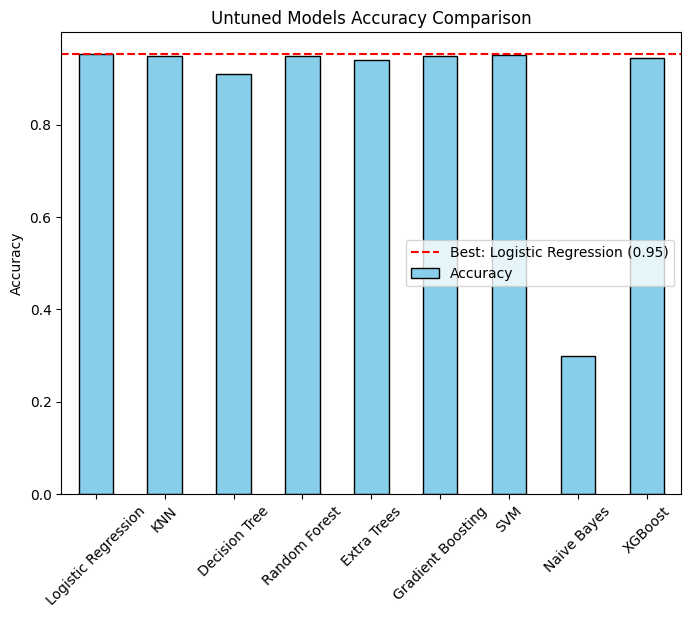

In [15]:
plt.figure(figsize=(8,6))
untuned_df["Accuracy"].plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(best_model_acc, color="red", linestyle="--", label=f"Best: {best_model_name} ({best_model_acc:.2f})")
plt.title("Untuned Models Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## **All Metrics for Untuned Models**

In [16]:
print("All Metrics for Untuned Models:\n")
display(untuned_df)

All Metrics for Untuned Models:



,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.952055,1.000000,0.02,0.039216,0.841770
KNN,0.948141,0.000000,0.00,0.000000,0.621420
Decision Tree,0.909002,0.169231,0.22,0.191304,0.582222
Random Forest,0.948141,0.285714,0.04,0.070175,0.792901
Extra Trees,0.940313,0.133333,0.04,0.061538,0.707788
Gradient Boosting,0.949119,0.250000,0.02,0.037037,0.835720
SVM,0.951076,0.000000,0.00,0.000000,0.638189
Naive Bayes,0.298434,0.064052,0.98,0.120245,0.786029
XGBoost,0.943249,0.250000,0.08,0.121212,0.804856


## **Classification Report & Confusion Matrix for best Untuned Model**

Best Untuned Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



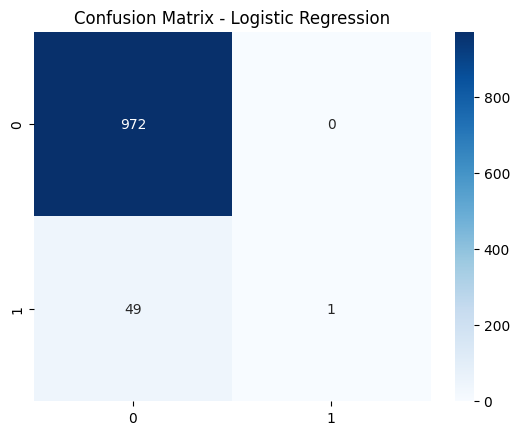

In [17]:
best_untuned_model = untuned_df["Accuracy"].idxmax()
print("Best Untuned Model:", best_untuned_model)

best_clf = Pipeline(steps=[('pre', preprocessor), ('model', models[best_untuned_model])])
best_clf.fit(X_train, y_train)
y_pred_best = best_clf.predict(X_test)

print(classification_report(y_test, y_pred_best))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_untuned_model}")
plt.show()

# **Step 7: Hyperparameter Tuning (GridSearchCV)**

## **Parameter grids for GridSearchCV**

In [18]:
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__solver": ["saga"], 
        "model__max_iter": [500, 1000]
    },
    
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan", "minkowski"]
    },
    
    "Decision Tree": {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    },
    
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    },
    
    "Extra Trees": {
        "model__n_estimators": [100, 200],
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5]
    },
    
    "Gradient Boosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__subsample": [0.8, 1.0]
    },
    
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf", "poly"],
        "model__gamma": ["scale", "auto"]
    },
    
    "Naive Bayes": {
        "model__var_smoothing": [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
    },
    
    "XGBoost": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]
    }
}

## **Train & Evaluate Tuned Models**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

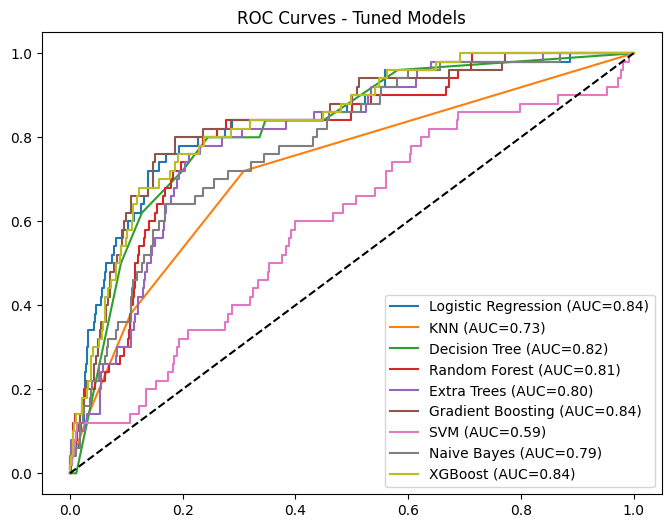

In [19]:
tuned_results = {}
plt.figure(figsize=(8,6))

for name, params in param_grids.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('model', models[name])])
    grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    tuned_results[name] = [acc, prec, rec, f1, roc]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves - Tuned Models")
plt.show()

In [20]:
tuned_df = pd.DataFrame(tuned_results, index=["Accuracy","Precision","Recall","F1","ROC-AUC"]).T

## **Tuned Models Accuracy**

In [21]:
print("\nTuned Models Accuracy:\n")
print(tuned_df[["Accuracy"]])

best_tuned_model_name = tuned_df["Accuracy"].idxmax()
best_tuned_model_acc = tuned_df["Accuracy"].max()

print(f"\nBest Tuned Model: {best_tuned_model_name} with Accuracy : {best_tuned_model_acc:.4f}")



Tuned Models Accuracy:

                     Accuracy
Logistic Regression  0.951076
KNN                  0.951076
Decision Tree        0.949119
Random Forest        0.951076
Extra Trees          0.951076
Gradient Boosting    0.949119
SVM                  0.951076
Naive Bayes          0.498043
XGBoost              0.951076

Best Tuned Model: Logistic Regression with Accuracy : 0.9511


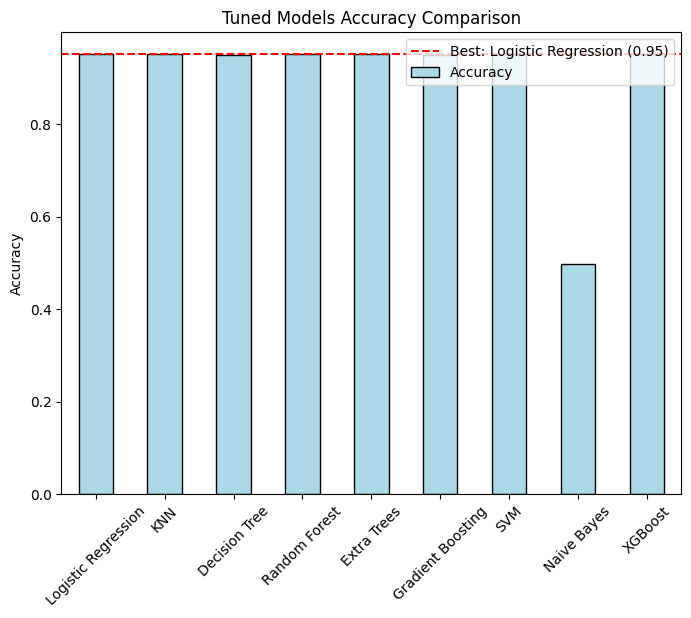

In [22]:
plt.figure(figsize=(8,6))
tuned_df["Accuracy"].plot(kind="bar", color="lightblue", edgecolor="black")
plt.axhline(best_tuned_model_acc, color="red", linestyle="--",
            label=f"Best: {best_tuned_model_name} ({best_tuned_model_acc:.2f})")
plt.title("Tuned Models Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## **All Metrics for Tuned Models**

In [23]:
print("All Metrics for Tuned Models:\n")
display(tuned_df)

All Metrics for Tuned Models:



,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.951076,0.000000,0.00,0.000000,0.840000
KNN,0.951076,0.000000,0.00,0.000000,0.727047
Decision Tree,0.949119,0.000000,0.00,0.000000,0.820175
Random Forest,0.951076,0.000000,0.00,0.000000,0.807634
Extra Trees,0.951076,0.000000,0.00,0.000000,0.800473
Gradient Boosting,0.949119,0.000000,0.00,0.000000,0.838951
SVM,0.951076,0.000000,0.00,0.000000,0.592449
Naive Bayes,0.498043,0.079855,0.88,0.146423,0.786029
XGBoost,0.951076,0.000000,0.00,0.000000,0.837593


## **Classification Report & Confusion Matrix for best Tuned Model**

Classification Report - Logistic Regression:

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



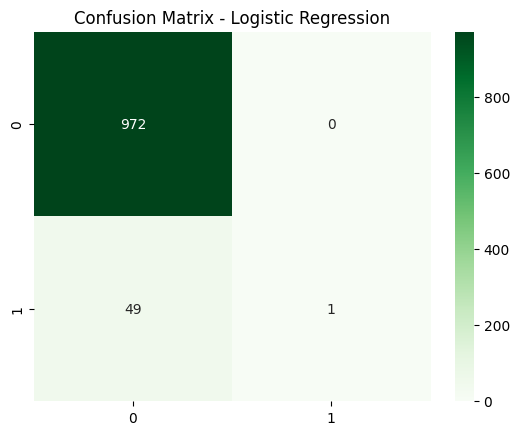

In [24]:
best_tuned_clf = Pipeline(steps=[('pre', preprocessor), ('model', models[best_tuned_model_name])])
best_tuned_clf.fit(X_train, y_train)
y_pred_tuned = best_tuned_clf.predict(X_test)

print(f"Classification Report - {best_tuned_model_name}:\n")
print(classification_report(y_test, y_pred_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt="d", cmap="Greens")
plt.title(f"Confusion Matrix - {best_tuned_model_name}")
plt.show()

# **Step 8: Compare Tuned vs Untuned all Matrics**

In [25]:
comparison_df = untuned_df.join(tuned_df, lsuffix="_untuned", rsuffix="_tuned")
print(comparison_df)

                     Accuracy_untuned  Precision_untuned  Recall_untuned  \
Logistic Regression          0.952055           1.000000            0.02   
KNN                          0.948141           0.000000            0.00   
Decision Tree                0.909002           0.169231            0.22   
Random Forest                0.948141           0.285714            0.04   
Extra Trees                  0.940313           0.133333            0.04   
Gradient Boosting            0.949119           0.250000            0.02   
SVM                          0.951076           0.000000            0.00   
Naive Bayes                  0.298434           0.064052            0.98   
XGBoost                      0.943249           0.250000            0.08   

                     F1_untuned  ROC-AUC_untuned  Accuracy_tuned  \
Logistic Regression    0.039216         0.841770        0.951076   
KNN                    0.000000         0.621420        0.951076   
Decision Tree          0.191304    

# **Step 9: Accuracy Comparison**

In [26]:
accuracy_comparison = untuned_df[["Accuracy"]].join(tuned_df[["Accuracy"]], lsuffix="_untuned", rsuffix="_tuned")
print("Accuracy Comparison (Untuned vs Tuned):\n")
display(accuracy_comparison)

Accuracy Comparison (Untuned vs Tuned):



,Accuracy_untuned,Accuracy_tuned
Logistic Regression,0.952055,0.951076
KNN,0.948141,0.951076
Decision Tree,0.909002,0.949119
Random Forest,0.948141,0.951076
Extra Trees,0.940313,0.951076
Gradient Boosting,0.949119,0.949119
SVM,0.951076,0.951076
Naive Bayes,0.298434,0.498043
XGBoost,0.943249,0.951076


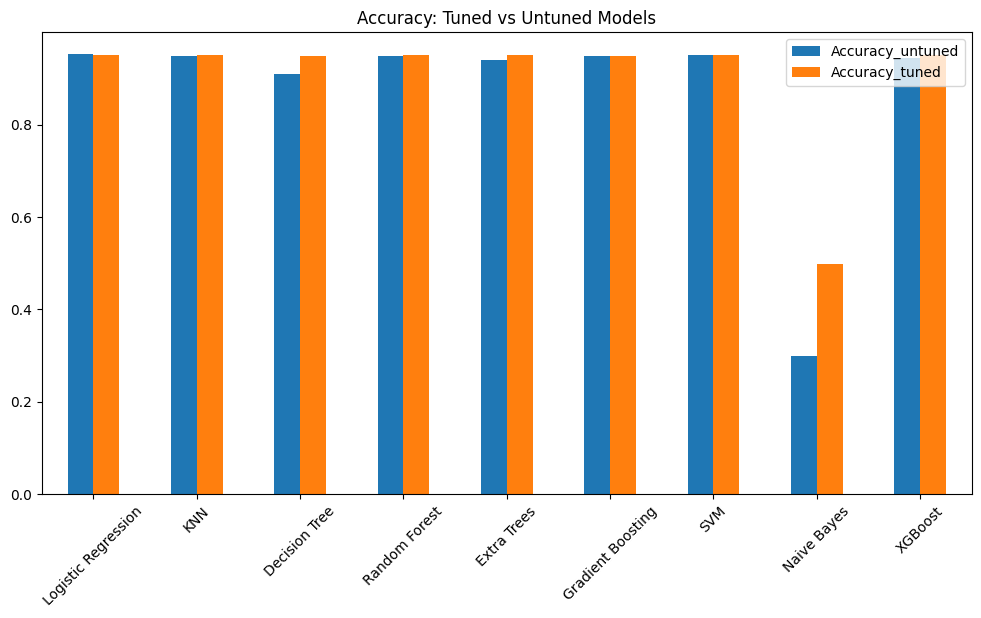

In [27]:
accuracy_comparison[["Accuracy_untuned","Accuracy_tuned"]].plot(kind="bar", figsize=(12,6))
plt.title("Accuracy: Tuned vs Untuned Models")
plt.xticks(rotation=45)
plt.show()

# **Step 10: Actual vs Predicted Comparison**

In [28]:
best_tuned_model = tuned_df["Accuracy"].idxmax()

best_untuned_clf = Pipeline(steps=[('pre', preprocessor), ('model', models[best_untuned_model])])
best_untuned_clf.fit(X_train, y_train)
y_pred_untuned = best_untuned_clf.predict(X_test)

best_tuned_clf = Pipeline(steps=[('pre', preprocessor), ('model', models[best_tuned_model])])
best_tuned_clf.fit(X_train, y_train)
y_pred_tuned = best_tuned_clf.predict(X_test)

compare_preds = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    f"Predicted_{best_untuned_model}_untuned": y_pred_untuned,
    f"Predicted_{best_tuned_model}_tuned": y_pred_tuned
})
compare_preds.sample(10, random_state=42)

,Actual,Predicted_Logistic Regression_untuned,Predicted_Logistic Regression_tuned
992,0,0,0
478,0,0,0
689,0,0,0
31,0,0,0
617,0,0,0
687,0,0,0
552,0,0,0
835,0,0,0
76,0,0,0
996,0,0,0
